In [1]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import math
import numpy
import random

def preprocess(size = 500):
    X = []
    y = []
    data = []
    first = True
    with open('data/adult_encoded.csv') as f:
        for l in f:
            if first:
                first = False
                continue
            data.append([float(k) for k in l.strip().split(',')[1:]])
    while len(y) == 0 or min(y) == max(y):
        for d in random.sample(data, size):
            X.append(d[:-1])
            y.append(d[-1])
    return numpy.asarray(X),numpy.asarray(y)

def get_model(predictor_type):
    deg = 3
    e = predictor_type.split('_')
    predictor = e[0]
    if predictor == "SVM":
        if len(e) == 2:
            kernel_type = e[1]
        else:
            kernel_type = 'rbf'
        original_model = svm.SVC(kernel=kernel_type, degree=deg)
    elif predictor == "DT":
        original_model = DecisionTreeClassifier()
    elif predictor == "KNN":
        original_model = KNeighborsClassifier()
    elif predictor == "RF":
        original_model = RandomForestClassifier()
    elif predictor == "NB":
        original_model = GaussianNB()
    return original_model

def generate_target_model(X, y, test_set_X, test_set_y, predictor_type="SVM"):
    traget_model = get_model(predictor_type)
    traget_model.fit(X, y)
    print "finish generating model"
    og_pred = traget_model.predict(test_set_X)
    og_acc = 0
    for i in range(len(og_pred)):
        if og_pred[i] == test_set_y[i]:
            og_acc += 1
    print "target model accuracy:", float(og_acc) / len(test_set_X)
    
    return traget_model, float(og_acc) / len(test_set_X)

def steal(target_model, query, dataset, attack_predictor="SVM", attack_type = "retraining"):
    #print query, attack_predictor, attack_type
    my_model = get_model(attack_predictor)
    predictor = attack_predictor.split('_')[0]
    X = []
    y = []
    if attack_predictor=="SVM" and query < 20:
        attack_type = "retraining"
        
    if attack_type == "retraining":
        while True:
            #my_model = svm.SVC()
            #my_model = DecisionTreeClassifier()
            
            for datum in random.sample(dataset, int(query)):
                b = target_model.predict([datum])
                X.append(datum)
                y.append(b)
                
            if min(y) == max(y):
                X = []
                y = []
                continue
                
            my_model.fit(X, numpy.ravel(y))
            break
        return my_model
    elif attack_type == "adaptive retraining":
        roundsize = max(int(query / 10),1)
        if len(dataset) >= query >= roundsize:
            pool = random.sample(dataset, int(query))
            n = roundsize
            t = math.ceil(query / n)
            for i in range(0, n):
                a = pool.pop()
                b = target_model.predict([a])[0]
                X.append(a)
                y.append(b)
            t -= 1

            while t > 0 and min(y) == max(y):
                X = []
                y = []
                for i in range(0, n):
                    if not pool:
                        break
                    a = pool.pop(0)
                    b = target_model.predict([a])[0]
                    X.append(a)
                    y.append(b)
                t -= 1
                #print("[*] Additional initial random round had to be done due to no variance")
            #my_model = svm.SVC()
            for i in range(0, int(t-1)):

                my_model.fit(X, numpy.ravel(y))
                
                if predictor == "SVM":
                    distances = my_model.decision_function(pool).tolist()
                else:
                    probs = my_model.predict_proba(pool).tolist()
                    #print "probs", probs[:10]
                    distances = []
                    for prob in probs:
                        distances.append(abs(prob[0] - prob[1]))
                    #print distances[:10]
                    
                for j in range(0, n):
                    if not pool:
                        break
                    idx = distances.index(min(distances))
                    distances = distances[:idx] + distances[idx+1:]
                    closest = pool.pop(idx)
                    X.append(closest)
                    y.append(target_model.predict([closest])[0])
            my_model.fit(X, numpy.ravel(y))
            return my_model
        else:
            print("[!] Error: dataset to small or roundsize bigger than query_budget")
            raise ValueError

def evaluate(target_model, steal_model, test_set_X, test_set_y):
    '''errors = 0
    for i in range(len(test_set_X)):
        target_predict = target_model.predict([test_set_X[i]])
        steal_predict = steal_model.predict([test_set_X[i]])
        if target_predict != steal_predict:
            errors += 1
    return 1 - (float(errors) / len(test_set_X))'''
    steal_pred = steal_model.predict(test_set_X)
    steal_acc = 0
    for i in range(len(steal_pred)):
        if steal_pred[i] == test_set_y[i]:
            steal_acc += 1
    return float(steal_acc) / len(test_set_X)

def plot_accuracy_on_queries(x_axis, y_axis, og_acc, target_predictor, attack_predictor, attack_type):
    plt.plot(x_axis, y_axis)
    plt.plot(x_axis, og_acc, label = "Original Classifier")
    #plt.title("Stolen Classifier Accuracy with Queries and Equation Solve Attack")
    plt.title("Steal %s with %s by %s"%(target_predictor, attack_predictor, attack_type))
    plt.xlabel("Number of Queries")
    plt.ylabel("Accuracy Proportion")
    plt.gca().legend(('Stolen Classifier','Original Classifier'))
    plt.xlim(0,140)
    plt.show()

def attack(target_predictor, attack_predictor, attack_type):
    X, y = preprocess(10000)
    
    train_rate = 0.6
    attack_rate = 0.34
    data_size = len(X)
    training_set_X = X[0:int(train_rate * data_size)]
    training_set_y = y[0:int(train_rate * data_size)]
    attacker_training = X[int(train_rate * data_size):int((train_rate + attack_rate) * data_size)]

    test_set_X = X[int((train_rate + attack_rate) * data_size):]
    test_set_y = y[int((train_rate + attack_rate) * data_size):]
    
    #print len(training_set_X)
    #print len(attacker_training)
    #print len(test_set_X)
        
    #target_model, og_acc = generate_target_model(training_set_X, training_set_y, test_set_X, test_set_y, kernel_type="linear")
    target_model, og_acc = generate_target_model(training_set_X, training_set_y, test_set_X, test_set_y, target_predictor)
    
    x_axis = []
    y_axis = []
    tries = 5
    for query in range(2, 140, 1):
        accuracies = []
        #print query
        for i in range(tries):
            while True:
                try:
                    steal_model = steal(target_model, query, attacker_training, attack_predictor, attack_type)
                    #return
                except:
                    continue
                break
            #return
            accuracy = evaluate(target_model, steal_model, test_set_X, test_set_y)
            accuracies.append(accuracy)
        #print query, accuracy
        x_axis.append(query)
        y_axis.append(float(sum(accuracies))/tries)
    #print x_axis
    #print y_axis
    #print [og_acc] * len(x_axis)
    plot_accuracy_on_queries(x_axis, y_axis, [og_acc] * len(x_axis), target_predictor, attack_predictor, attack_type)
    return 1 - sum(y_axis) / sum([og_acc] * len(x_axis))


target:DT	attack:DT	method:retraining
finish generating model
target model accuracy: 0.798333333333


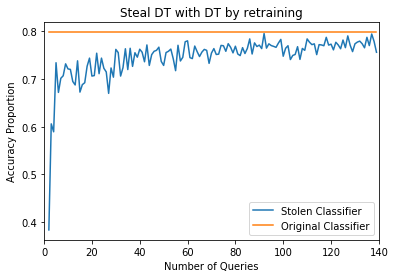

index: 0.063867961635
target:RF	attack:DT	method:retraining


/usr/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


finish generating model
target model accuracy: 0.845


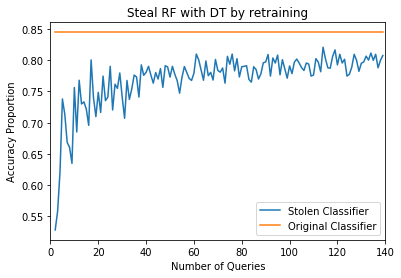

index: 0.0875196524026
target:SVM	attack:DT	method:retraining


/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


finish generating model
target model accuracy: 0.846666666667


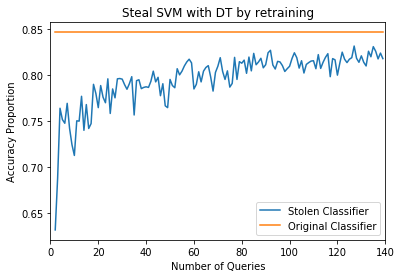

index: 0.0594459659934
target:NB	attack:DT	method:retraining
finish generating model
target model accuracy: 0.82


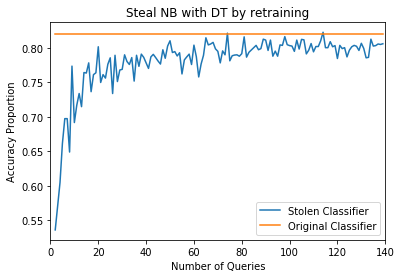

index: 0.0480705785319
target:KNN	attack:DT	method:retraining
finish generating model
target model accuracy: 0.825


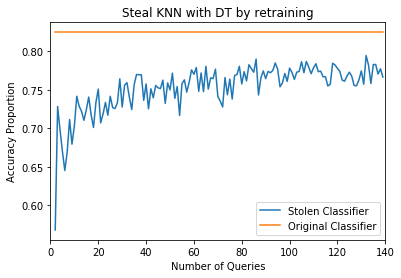

index: 0.0872375933246
target:DT	attack:RF	method:retraining
finish generating model
target model accuracy: 0.823333333333


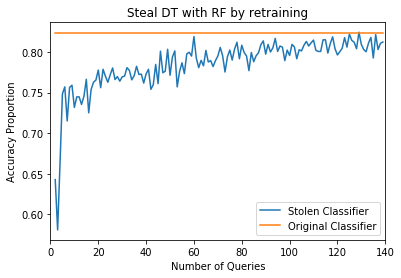

index: 0.0464560230006
target:RF	attack:RF	method:retraining
finish generating model
target model accuracy: 0.825


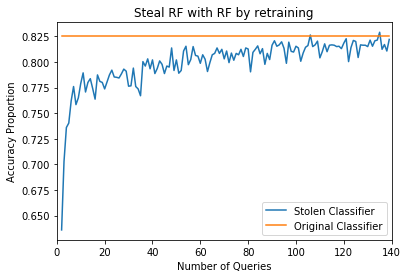

index: 0.0309266578832
target:SVM	attack:RF	method:retraining
finish generating model
target model accuracy: 0.85


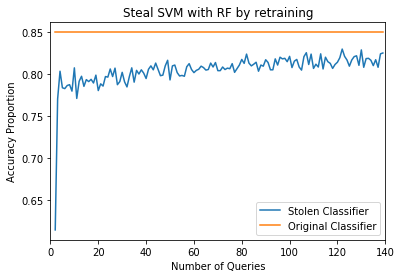

index: 0.0527024722933
target:NB	attack:RF	method:retraining
finish generating model
target model accuracy: 0.83


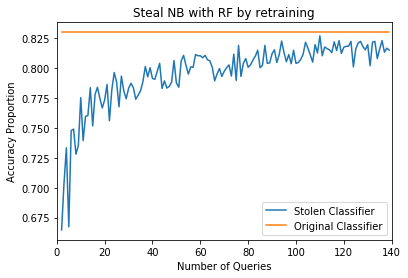

index: 0.0411210057622
target:KNN	attack:RF	method:retraining
finish generating model
target model accuracy: 0.863333333333


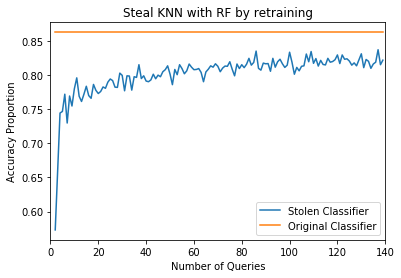

index: 0.0705612444743
target:DT	attack:SVM	method:retraining
finish generating model
target model accuracy: 0.825


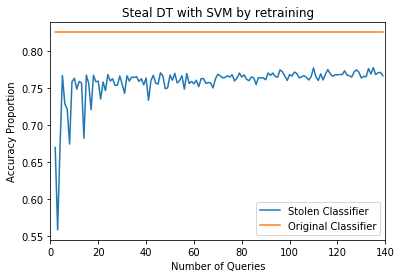

index: 0.0811623481189
target:RF	attack:SVM	method:retraining
finish generating model
target model accuracy: 0.841666666667


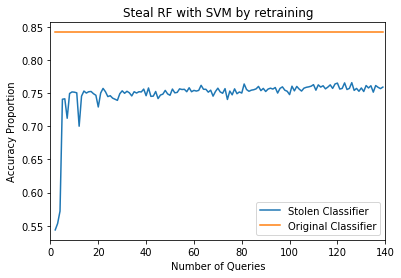

index: 0.110773425169
target:SVM	attack:SVM	method:retraining
finish generating model
target model accuracy: 0.845


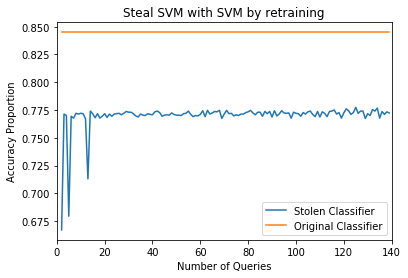

index: 0.0890232398594
target:NB	attack:SVM	method:retraining
finish generating model
target model accuracy: 0.795


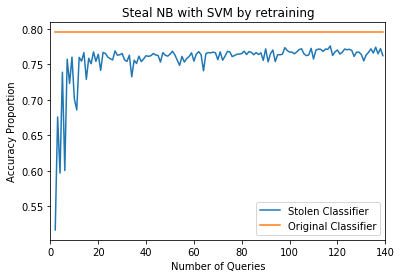

index: 0.0484185580166
target:KNN	attack:SVM	method:retraining
finish generating model
target model accuracy: 0.841666666667


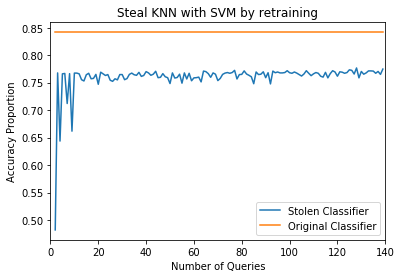

index: 0.0967341081934
target:DT	attack:NB	method:retraining
finish generating model
target model accuracy: 0.798333333333


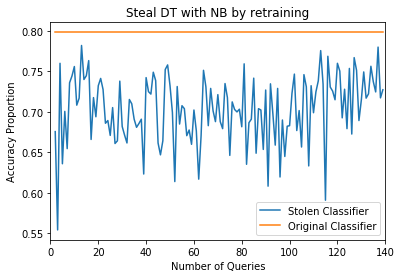

index: 0.118628785816
target:RF	attack:NB	method:retraining
finish generating model
target model accuracy: 0.84


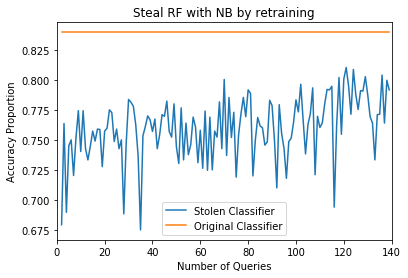

index: 0.0947463768116
target:SVM	attack:NB	method:retraining
finish generating model
target model accuracy: 0.846666666667


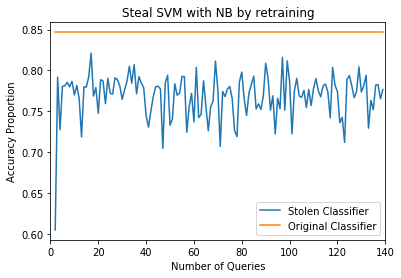

index: 0.0916124614858
target:NB	attack:NB	method:retraining
finish generating model
target model accuracy: 0.828333333333


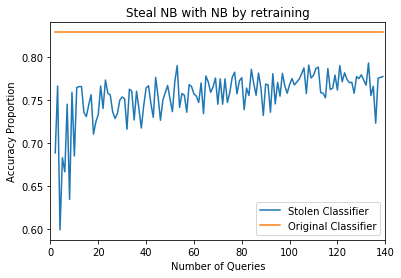

index: 0.0876884495378
target:KNN	attack:NB	method:retraining
finish generating model
target model accuracy: 0.841666666667


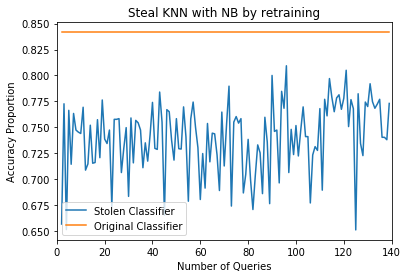

index: 0.120674415268


In [2]:
#test retraining
targets = ["DT","RF","SVM","NB","KNN"]
retraining_model = ["DT","RF","SVM","NB"]

for attack_model in retraining_model:
    for target_model in targets:
        print "target:%s\tattack:%s\tmethod:%s"%(target_model, attack_model, "retraining")
        index = attack(target_model, attack_model, "retraining")
        print "index:", index

-------------------
target:DT	attack:RF	method:adaptive_retraining
finish generating model
target model accuracy: 0.833333333333


/usr/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


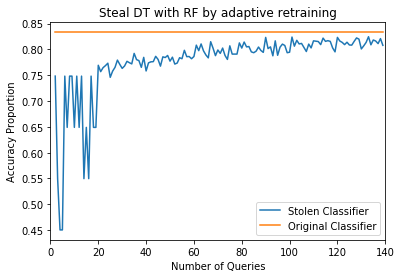

index: 0.0681333333333
-------------------
target:RF	attack:RF	method:adaptive_retraining
finish generating model
target model accuracy: 0.813333333333


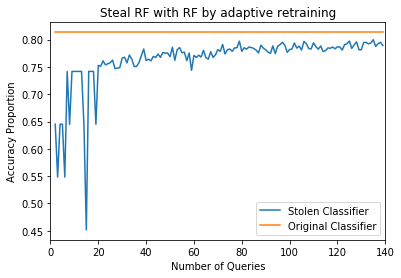

index: 0.0609408410549
-------------------
target:SVM	attack:RF	method:adaptive_retraining


/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


finish generating model
target model accuracy: 0.836666666667


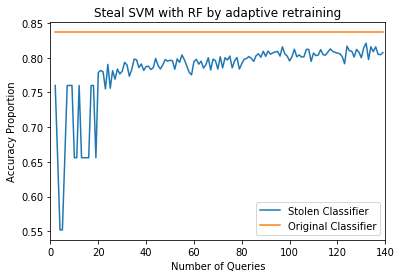

index: 0.0650412841388
-------------------
target:NB	attack:RF	method:adaptive_retraining
finish generating model
target model accuracy: 0.815


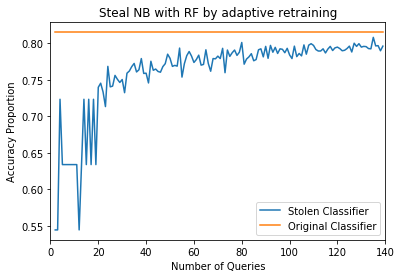

index: 0.0664918052221
-------------------
target:KNN	attack:RF	method:adaptive_retraining
finish generating model
target model accuracy: 0.833333333333


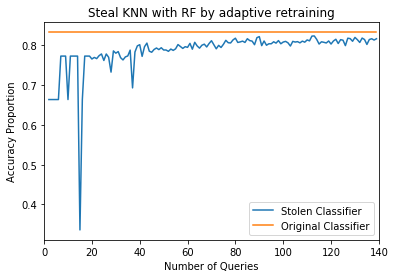

index: 0.0553275362319
-------------------
target:DT	attack:SVM	method:adaptive_retraining
finish generating model
target model accuracy: 0.795


In [ ]:
#test RF adaptive_retraining
targets = ["DT","RF","SVM","NB","KNN"]
adaptive_retraining_model = ["RF"]

for attack_model in adaptive_retraining_model:
    for target_model in targets:
        print "-------------------"
        print "target:%s\tattack:%s\tmethod:%s"%(target_model, attack_model, "adaptive_retraining")
        index = attack(target_model, attack_model, "adaptive retraining")
        print "index:", index

-------------------
target:DT	attack:NB	method:adaptive_retraining
finish generating model
target model accuracy: 0.806666666667


/usr/local/lib/python2.7/site-packages/sklearn/naive_bayes.py:436: RuntimeWarning: divide by zero encountered in log
  n_ij = - 0.5 * np.sum(np.log(2. * np.pi * self.sigma_[i, :]))
/usr/local/lib/python2.7/site-packages/sklearn/naive_bayes.py:438: RuntimeWarning: divide by zero encountered in divide
  (self.sigma_[i, :]), 1)
/usr/local/lib/python2.7/site-packages/sklearn/naive_bayes.py:438: RuntimeWarning: invalid value encountered in divide
  (self.sigma_[i, :]), 1)


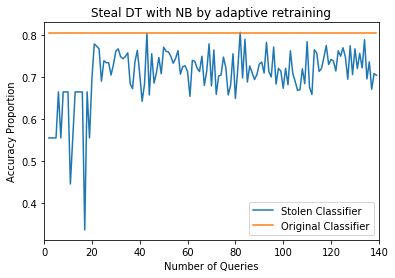

index: 0.122427835669
-------------------
target:RF	attack:NB	method:adaptive_retraining


/usr/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


finish generating model
target model accuracy: 0.826666666667


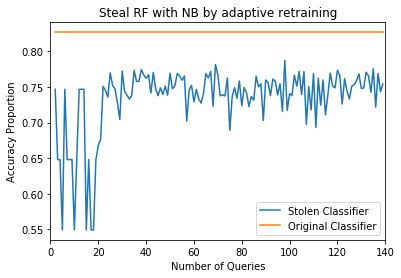

index: 0.11268115942
-------------------
target:SVM	attack:NB	method:adaptive_retraining


/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


finish generating model
target model accuracy: 0.875


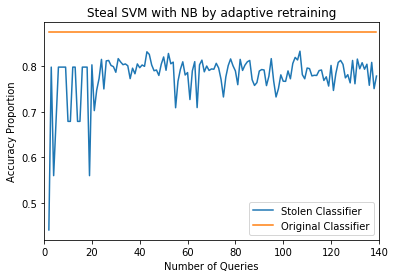

index: 0.109424430642
-------------------
target:NB	attack:NB	method:adaptive_retraining
finish generating model
target model accuracy: 0.836666666667


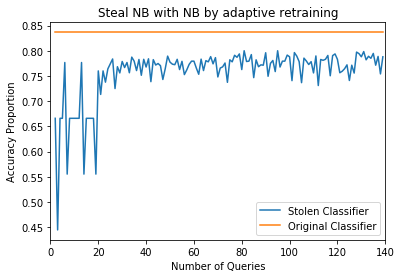

index: 0.0961833824124
-------------------
target:KNN	attack:NB	method:adaptive_retraining
finish generating model
target model accuracy: 0.86


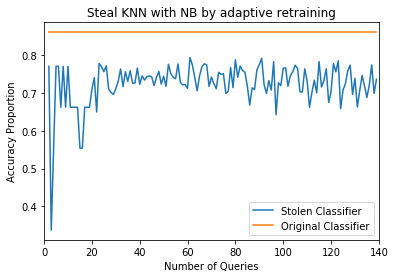

index: 0.158046848669


In [3]:
#test NB adaptive_retraining
targets = ["DT","RF","SVM","NB","KNN"]
adaptive_retraining_model = ["NB"]

for attack_model in adaptive_retraining_model:
    for target_model in targets:
        print "-------------------"
        print "target:%s\tattack:%s\tmethod:%s"%(target_model, attack_model, "adaptive_retraining")
        index = attack(target_model, attack_model, "adaptive retraining")
        print "index:", index

-------------------
target:DT	attack:SVM	method:adaptive_retraining
finish generating model
target model accuracy: 0.811666666667


/usr/local/lib/python2.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


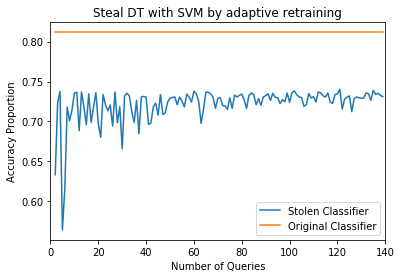

index: 0.110701425468
-------------------
target:RF	attack:SVM	method:adaptive_retraining


/usr/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


finish generating model
target model accuracy: 0.853333333333


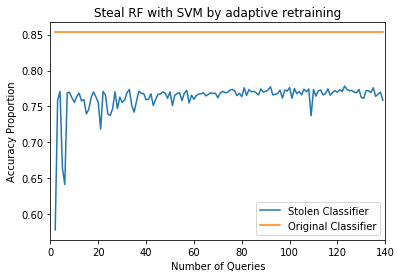

index: 0.106408514493
-------------------
target:SVM	attack:SVM	method:adaptive_retraining
finish generating model
target model accuracy: 0.84


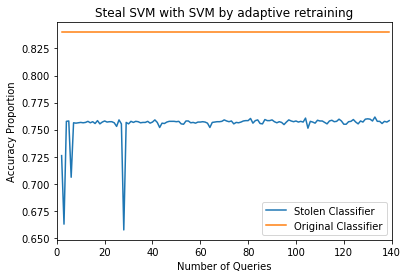

index: 0.101023694502
-------------------
target:NB	attack:SVM	method:adaptive_retraining
finish generating model
target model accuracy: 0.836666666667


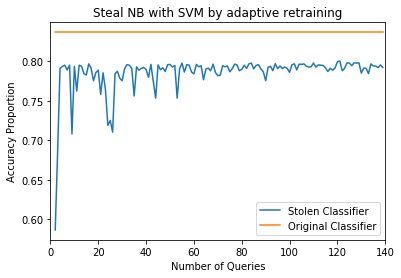

index: 0.0612997286217
-------------------
target:KNN	attack:SVM	method:adaptive_retraining
finish generating model
target model accuracy: 0.851666666667


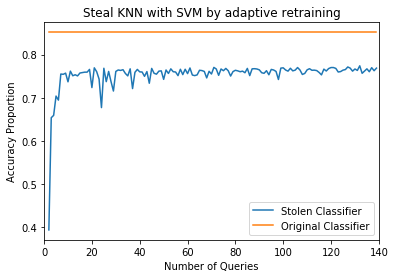

index: 0.114787713775


In [2]:
#test SVM adaptive_retraining
targets = ["DT","RF","SVM","NB","KNN"]
adaptive_retraining_model = ["SVM"]

for attack_model in adaptive_retraining_model:
    for target_model in targets:
        print "-------------------"
        print "target:%s\tattack:%s\tmethod:%s"%(target_model, attack_model, "adaptive_retraining")
        index = attack(target_model, attack_model, "adaptive retraining")
        print "index:", index
        